In [4]:
import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
import os
import numpy as np
import torchvision
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from statistics import mean
import pandas as pd
import torch

from VAE_Architectures import VAE
from utils import create_dataset_train_test_split, get_train_images, plot_vae_images, create_loss_plot, validation


This file is used to find the optimal VAE architecture by varying the hyperparameters and number of layers and by selecting the optimal architecture.

To fix the seed, the function seed_everything from the pytorch_lightning library is used, as well as manual_seed from torch.

This model is described in the paper under Autoencoder-based generative model.

In [5]:
seed_everything(41)
torch.use_deterministic_algorithms(True)
torch.manual_seed(41)

Global seed set to 41


In [6]:
batch_size = 64
crop_size = 128
kl_coeff = 0.01
lr = 1e-3
num_of_channels = 1
max_epochs = 40
run_id = "Results_VAE_Final_Validation"
path_to_data = "G:/Nanomaterial_Morphology_Prediction/Datasets/Final_Image_Dataset/"

In [7]:
save_path = "Results_VAE/{r}/".format(r=run_id)
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
dataset_train, dataset_test, dataset_val, dataloader_train, dataloader_test, dataloader_val = create_dataset_train_test_split(
    path_to_data, batch_size, crop_size, num_of_channels
)

In [6]:
class GenerateCallback(pl.Callback):
    def __init__(self, input_images, save_path, every_n_epochs=1):
        super().__init__()
        self.input_images = input_images
        self.every_n_epochs = every_n_epochs
        self.save_path = save_path

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            image_save_path = self.save_path + "Images/epoch_{e}/".format(
                e=trainer.current_epoch
            )
            if not os.path.exists(image_save_path):
                os.makedirs(image_save_path)

            input_images = self.input_images.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconstructed_images = pl_module(input_images)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_images, reconstructed_images], dim=1).flatten(
                0, 1
            )
            grid = torchvision.utils.make_grid(
                imgs, nrow=2, normalize=True, range=(-1, 1)
            )
            trainer.logger.experiment.add_image(
                "Reconstructions", grid, global_step=trainer.global_step
            )

            psnr_metrics, ssim_metrics = plot_vae_images(
                input_images, reconstructed_images, image_save_path
            )

            df_metrics = pd.read_csv(self.save_path + "df_metrics.csv")
            df_metrics.loc[len(df_metrics)] = [
                trainer.current_epoch,
                mean(psnr_metrics),
                mean(ssim_metrics),
            ]
            df_metrics.to_csv(self.save_path + "df_metrics.csv", index=False)

In [7]:
def Train_VAE(run_id):
    vae = VAE(crop_size, lr=lr, kl_coeff=kl_coeff, enc_type = "4_layers")
    logger = TensorBoardLogger("Results_VAE", name=run_id)
    trainer = pl.Trainer(
        gpus=1,
        logger=logger,
        max_epochs=max_epochs,
        callbacks=[
            GenerateCallback(get_train_images(10, dataset_test), every_n_epochs=1, save_path=save_path)
        ],
        log_every_n_steps=5,
        auto_lr_find=False,
        auto_scale_batch_size=False,
    )
    return trainer, vae


In [8]:
df_metrics = pd.DataFrame(columns=["Epoch", "PSNR", "SSIM"])
df_metrics.to_csv(save_path + "df_metrics.csv", index=False)

In [ ]:
trainer, ae = Train_VAE(run_id)


In [ ]:
trainer.fit(ae, dataloader_train)


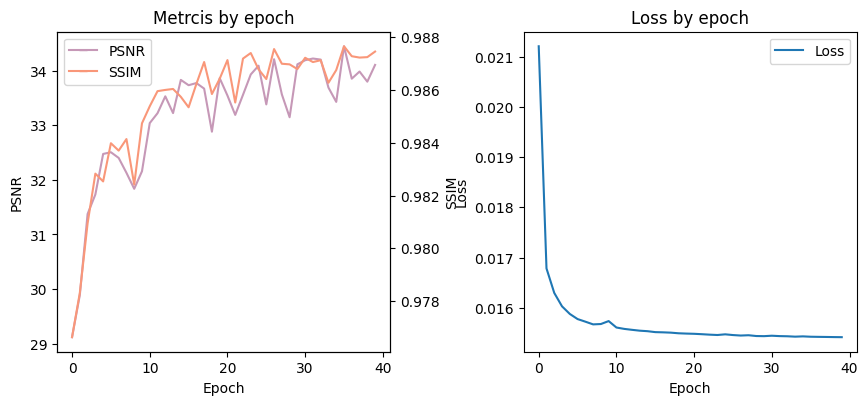

In [12]:
create_loss_plot('Results_VAE/Results_VAE_Final_Validation/version_0/events.out.tfevents.1691835076.I.30808.0', save_path)

In [13]:
psnr_metrics, ssim_metrics = validation(dataset_val, 'Results_VAE/Results_VAE_Final_Validation/version_0/checkpoints/epoch=39-step=26320.ckpt', save_path, 100)

In [14]:
print("Validation PSNR:", mean(psnr_metrics))
print("Validation SSIM:", mean(ssim_metrics))

Validation PSNR: 34.07629137039184
Validation SSIM: 0.9842331629991531
